# Fresnel Equations (by Python)

#### import packages

In [1]:
import numpy as np
π = np.pi

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# packages for interaction in Jupyter notebook
from ipywidgets import interact
import ipywidgets as widgets

#### define the `Fresnel` fucntion

In [2]:
# define a function to conveniently plot a line connecting two points
def plotline(ax, point1,point2, **kwargs):
    ax.plot(
        [ point1[0], point2[0] ],
        [ point1[1], point2[1] ],
        [ point1[2], point2[2] ],
        **kwargs
    )

def Fresnel(n1,n2, θi, vector_magnitude, azimuthal,elevation):
    
    # angles
    θi = np.deg2rad(θi)
    θt = np.arcsin(n1/n2 * np.sin(θi) +0j)
    θt = θt.real if θt.imag==0 else θt # get rid of the imaginary part if θt is real
    θb = np.arctan(n2/n1    ) # Brewster angle
    θc = np.arcsin(n2/n1 +0j) # critical angle of total internal reflection
    total_reflection = False if n1<=n2 else θi>θc.real
    
    # complex reflection coefficients
    Sr = (n1 * np.cos(θi) - n2 * np.cos(θt)) / (n1 * np.cos(θi) + n2 * np.cos(θt))
    Pr = (n2 * np.cos(θi) - n1 * np.cos(θt)) / (n2 * np.cos(θi) + n1 * np.cos(θt))
    Sr = [np.abs(Sr), -np.angle(Sr)]
    Pr = [np.abs(Pr), -np.angle(Pr)]
    # transmission coefficients
    St = 2*n1 * np.cos(θi) / (n1 * np.cos(θi) + n2 * np.cos(θt))
    Pt = 2*n1 * np.cos(θi) / (n2 * np.cos(θi) + n1 * np.cos(θt))
    # intensity and power
    if vector_magnitude=='Intensity':
        Sr[0] = Sr[0]**2; St = n2/n1 * St**2
        Pr[0] = Pr[0]**2; Pt = n2/n1 * Pt**2
    if vector_magnitude=='Power':
        Sr[0] = Sr[0]**2; St = np.cos(θt)/np.cos(θi) * n2/n1 * St**2 if St!=0 else St
        Pr[0] = Pr[0]**2; Pt = np.cos(θt)/np.cos(θi) * n2/n1 * Pt**2 if Pt!=0 else Pt
        # examine if St,Pt==0 to avoid cos(90°)==0
        
    # create the figure object
    figure = plt.figure(constrained_layout=True, figsize=(5,5)); plt.close()
    spec = figure.add_gridspec(nrows=3,ncols=1, height_ratios=[1,2,8])
    # add subplots to the figure object
    table1 = figure.add_subplot(spec[0,0])
    table2 = figure.add_subplot(spec[1,0])
    fig =    figure.add_subplot(spec[2,0], projection='3d')
    # set plot options
    table1.axis('off'); table2.axis('off'); fig.axis('off')
    fig.grid(False)
    fig.set_box_aspect((1,1,1))
    fig.view_init(elevation,azimuthal)
    plotrange = 2
    fig.set_xlim3d(-plotrange,plotrange)
    fig.set_ylim3d(-plotrange,plotrange)
    fig.set_zlim3d(-plotrange,plotrange)
    
    # create the table of parameters
    table1.table(
        cellLoc = 'left',
        cellText = [
            [r"$n_1=%.2f$"%n1,r"$n_2=%.2f$"%n2],
            [r"$\theta_b=%.2f$"%(np.rad2deg(θb)),r"$\theta_c=%.2f+%.2fj$"%(np.rad2deg(θc.real),np.rad2deg(θc.imag))],
        ],
        loc = 'center'
    )
    table2.table(
        colLabels = ['incident','reflected','transmitted'],
        rowLabels = ['angle','S (%s)'%vector_magnitude,'P (%s)'%vector_magnitude],
        cellLoc = 'center',
        cellText = [
            ['%.2f'%(np.rad2deg(θi)), '%.2f'%(np.rad2deg(θi)), '%.2f+%.2fj'%(np.rad2deg(θt.real),np.rad2deg(θt.imag))],
            ['1', '%.2f∠%.2f'%(Sr[0],np.rad2deg(Sr[1])), 'evanescent' if total_reflection else '%.2f'%St],
            ['1', '%.2f∠%.2f'%(Pr[0],np.rad2deg(Pr[1])), 'evanescent' if total_reflection else '%.2f'%Pt]
        ],
        loc = 'center'
    )
    
    # plot interface of medium
    plotline(fig, [-plotrange,0,0],[plotrange,0,0], linewidth=1, color='tab:gray')
    plotline(fig, [0,-plotrange,0],[0,plotrange,0], linewidth=1, color='tab:gray')
    # plot normal line
    plotline(fig, [0,0,-plotrange],[0,0,plotrange], linewidth=1, color='tab:gray', linestyle='dashed')
    
    # points to draw light vectors
    iPoint = plotrange/2 * np.array([-np.sin(θi),0, np.cos(θi)])
    rPoint = plotrange/2 * np.array([ np.sin(θi),0, np.cos(θi)])
    tPoint = plotrange/2 * np.array([ np.sin(θt),0,-np.cos(θt)])
    # plot light beams
    plotline(fig, [0,0,0],2*iPoint, linewidth=1, color='goldenrod')
    plotline(fig, [0,0,0],2*rPoint, linewidth=1, color='gold')
    plotline(fig, [0,0,0],2*tPoint, linewidth=1, color='gold') if not total_reflection else 0
    
    # plot light vectors
    # represent phase shift of reflected light by a counterclockwise rotation of the light vetors
    # S light
    plotline(fig, iPoint, iPoint +                        np.array([0,-1,0])                                                       , color='tab:blue')
    plotline(fig, rPoint, rPoint + Sr[0]* ( np.cos(Sr[1])*np.array([0,-1,0]) + np.sin(Sr[1])*np.array([np.cos(θi),0,-np.sin(θi)]) ), color='tab:blue')
    plotline(fig, tPoint, tPoint + St   *                 np.array([0,-1,0])                                                       , color='tab:blue')  if not total_reflection else 0
    # P light
    plotline(fig, iPoint, iPoint +                        np.array([ np.cos(θi),0,np.sin(θi)])                                     , color='tab:orange')
    plotline(fig, rPoint, rPoint + Pr[0]* ( np.cos(Pr[1])*np.array([-np.cos(θi),0,np.sin(θi)]) + np.sin(Pr[1])*np.array([0,-1,0]) ), color='tab:orange')
    plotline(fig, tPoint, tPoint + Pt   *                 np.array([ np.cos(θt),0,np.sin(θt)])                                     , color='tab:orange') if not total_reflection else 0
    
    # return
    return figure

#### plot a static figure

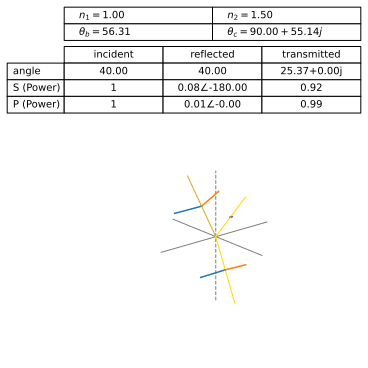

In [3]:
Fresnel(1,1.5, 40, 'Power', -40,20)

#### create an interactive interface

In [ ]:
interact(Fresnel,
    n1 = widgets.FloatSlider(min=1,max=2,step=0.1, value=  1, description=r"$n_1$"),
    n2 = widgets.FloatSlider(min=1,max=2,step=0.1, value=1.5, description=r"$n_2$"),
    θi = widgets.IntSlider(min=0,max=90,step=1, value=0, description=r"$\theta_i$"),
    vector_magnitude = widgets.ToggleButtons(options=['Amplitude','Intensity','Power'], value='Power', description='vector amplitude'),
    azimuthal = widgets.IntSlider(min=-180,max=180,step=10, value=-40, description='azimuthal'),
    elevation = widgets.IntSlider(min= -90,max= 90,step=10, value= 20, description='elevation')
);